In [1]:
import os
import numpy as np
import json
import uuid
from datetime import datetime
from pymongo import MongoClient, ASCENDING
import networkx as nx
from itertools import combinations
from collections import defaultdict
from sklearn.metrics.pairwise import cosine_similarity
from flask import Flask, request, jsonify
import mysql.connector
from mysql.connector import Error
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve
import warnings
warnings.filterwarnings('ignore')

import spacy
nlp = spacy.load("en_core_web_md")

# ------------------ Vector Database Configuration ------------------ #

In [2]:
DB_CONFIG = {
    'host': 'localhost',
    'user': 'root',
    'password': 'root',
    'database': 'vector_db'
}

# ------------------ Mongodb Configuration ------------------ #

In [3]:
MONGODB_URI = "mongodb://localhost:27017"
_mongo = MongoClient(MONGODB_URI)
mdb = _mongo["community_db"]
COMM = mdb["communities"]
DB_NAME = "community_db"
COLLECTION = "communities"

# ------------------ Utility Functions ------------------ #

In [4]:
def keep_nouns_adjs(text):
    doc = nlp(text)
    tokens = [
        token.lemma_.lower()
        for token in doc
        if token.pos_ in ["NOUN", "PROPN", "ADJ"] and not token.is_stop and not token.is_punct
    ]
    return " ".join(tokens)

def text_to_vector(text):
    clean_text = keep_nouns_adjs(text)
    doc = nlp(clean_text)
    return doc.vector

# ------------------ Vector Database Class ------------------ #

In [5]:
class VectorDatabase:
    def __init__(self, db_config, similarity_threshold=0.6):
        self.similarity_threshold = similarity_threshold
        self.db_config = db_config
        self._init_db()
    
    def _connect(self):
        return mysql.connector.connect(**self.db_config)
    
    def _init_db(self):
        conn = self._connect()
        cursor = conn.cursor()
        cursor.execute("""
            CREATE TABLE IF NOT EXISTS vector_database (
                id VARCHAR(255) PRIMARY KEY,
                text TEXT NOT NULL,
                vector TEXT NOT NULL,
                timestamp VARCHAR(50) NOT NULL
            )
        """)
        conn.commit()
        cursor.close()
        conn.close()
    
    def add_or_find_duplicate(self, text):
        sim = 0.0
        new_vector = text_to_vector(text)
        conn = self._connect()
        cursor = conn.cursor()
        cursor.execute("SELECT id, text, vector, timestamp FROM vector_database")
        rows = cursor.fetchall()
        
        
        for row in rows:
            entry_id, entry_text, entry_vector_json, timestamp = row
            entry_vector = np.array(json.loads(entry_vector_json))
            sim = cosine_similarity(new_vector.reshape(1, -1), entry_vector.reshape(1, -1))[0][0]
            
            if sim >= self.similarity_threshold:
                cursor.close()
                conn.close()
                return {
                    'status': 'duplicate',
                    'similarity': sim,
                    'id': entry_id,
                    'text': entry_text,
                    'timestamp': timestamp
                }
        
        entry_id = str(uuid.uuid4())[:8]
        timestamp = datetime.now().isoformat()
        cursor.execute(
            "INSERT INTO vector_database (id, text, vector, timestamp) VALUES (%s, %s, %s, %s)",
            (entry_id, text, json.dumps(new_vector.tolist()), timestamp)
        )
        conn.commit()
        cursor.close()
        conn.close()
        
        return {
            'status': 'added',
            'similarity':sim,
            'id': entry_id,
            'text': text,
            'timestamp': timestamp
        }
    
    def calculate_similarity(self, text1, text2):
        """Calculate similarity between two texts without adding to database"""
        vec1 = text_to_vector(text1)
        vec2 = text_to_vector(text2)
        sim = cosine_similarity(vec1.reshape(1, -1), vec2.reshape(1, -1))[0][0]
        return sim
    
    def clear_database(self):
        """Clear all entries from the database"""
        conn = self._connect()
        cursor = conn.cursor()
        cursor.execute("DELETE FROM vector_database")
        conn.commit()
        cursor.close()
        conn.close()

# ------------------ Testing With Synthetic Dataset ------------------ #

In [6]:
df = pd.read_csv(r"C:\Users\Dhineshkumar\Downloads\interest_pairs_100.csv")
df.head()

,text1,text2,label
0,I love the ocean breeze and sandy shores.,Gardening on weekends helps me connect with na...,0
1,Shooting landscapes and street scenes is my ho...,I love photographing sunsets and everyday life...,1
2,"Stories about wizards, dragons, and epic quest...",Running each morning keeps me healthy and focu...,0
3,Exploring fresh songs and curating playlists i...,I enjoy listening to new tracks and sharing pl...,1
4,I like discovering new music and building play...,Finding new artists and organizing playlists m...,1


In [7]:
similarity_threshold = 0.6
db = VectorDatabase(DB_CONFIG, similarity_threshold=similarity_threshold)
db.clear_database()

In [8]:
predictions = []
true_labels = []
similarity_scores = []

for idx, row in df.iterrows():
    text1 = row['text1']
    text2 = row['text2']
    true_label = int(row['label'])
    
    # Step 1: clear DB
    db.clear_database()
    
    # Step 2: insert text1
    db.add_or_find_duplicate(text1)
    
    # Step 3: compute similarity by calling the DB method on text2
    result = db.add_or_find_duplicate(text2)
    sim = result.get('similarity', 0.0)
    
    # Step 4: store results
    similarity_scores.append(sim)
    pred = 1 if sim >= similarity_threshold else 0
    predictions.append(pred)
    true_labels.append(true_label)
    
    # Step 5: optional debugging output
    if idx < 5:
        print(f"[{idx}]\ttext1[:60]: {text1[:60]!s}")
        print(f"\ttext2[:60]: {text2[:60]!s}")
        print(f"\tsim={sim:.4f}  true={true_label} pred={pred}\n")

[0]	text1[:60]: I love the ocean breeze and sandy shores.
	text2[:60]: Gardening on weekends helps me connect with nature.
	sim=0.1100  true=0 pred=0

[1]	text1[:60]: Shooting landscapes and street scenes is my hobby.
	text2[:60]: I love photographing sunsets and everyday life in the city.
	sim=0.5112  true=1 pred=0

[2]	text1[:60]: Stories about wizards, dragons, and epic quests are my favor
	text2[:60]: Running each morning keeps me healthy and focused.
	sim=0.4271  true=0 pred=0

[3]	text1[:60]: Exploring fresh songs and curating playlists is fun for me.
	text2[:60]: I enjoy listening to new tracks and sharing playlists with f
	sim=0.7522  true=1 pred=1

[4]	text1[:60]: I like discovering new music and building playlists.
	text2[:60]: Finding new artists and organizing playlists makes my day.
	sim=0.6891  true=1 pred=1



# ------------------ Metrics ------------------

In [9]:
cm = confusion_matrix(true_labels, predictions)
tn, fp, fn, tp = cm.ravel()

accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp) if (tp + fp) else 0
recall = tp / (tp + fn) if (tp + fn) else 0
f1_score = 2 * precision * recall / (precision + recall) if (precision + recall) else 0
specificity = tn / (tn + fp) if (tn + fp) else 0

print("\n" + "=" * 70)
print("FINAL EVALUATION RESULTS")
print("=" * 70)
print(f"Accuracy     : {accuracy:.3f}")
print(f"Precision    : {precision:.3f}")
print(f"Recall       : {recall:.3f}")
print(f"F1-Score     : {f1_score:.3f}")
print(f"Specificity  : {specificity:.3f}")
print()
print(f"True Positives : {tp}")
print(f"True Negatives : {tn}")
print(f"False Positives: {fp}")
print(f"False Negatives: {fn}")
print("=" * 70)


FINAL EVALUATION RESULTS
Accuracy     : 0.760
Precision    : 0.974
Recall       : 0.617
F1-Score     : 0.755
Specificity  : 0.975

True Positives : 37
True Negatives : 39
False Positives: 1
False Negatives: 23


## Confusion Matrix

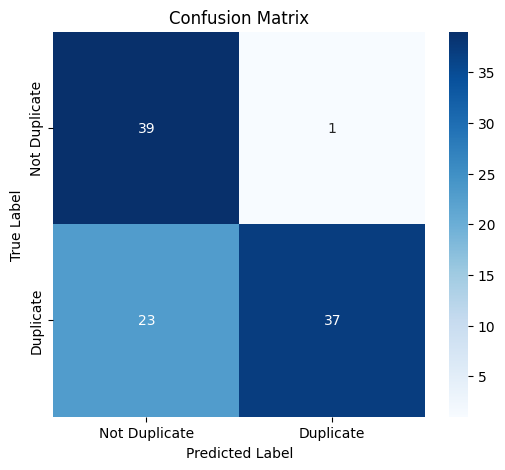

In [10]:
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Duplicate', 'Duplicate'],
            yticklabels=['Not Duplicate', 'Duplicate'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## Bar Chart

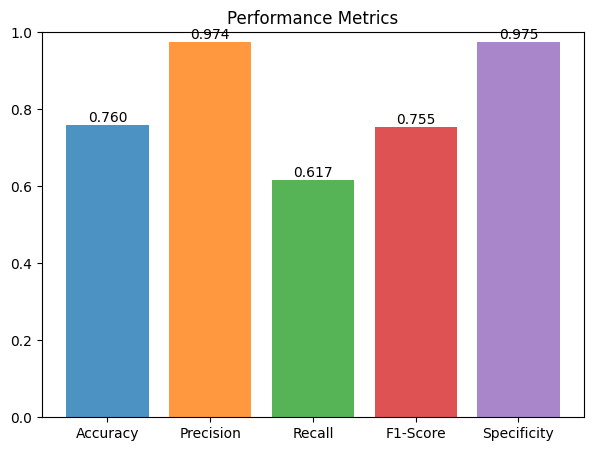

In [11]:
plt.figure(figsize=(7, 5))
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'Specificity']
values = [accuracy, precision, recall, f1_score, specificity]
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
bars = plt.bar(metrics, values, color=colors, alpha=0.8)
plt.ylim(0, 1)
plt.title('Performance Metrics')
for bar in bars:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
             f"{bar.get_height():.3f}", ha='center', va='bottom')
plt.show()

## ROC Curve

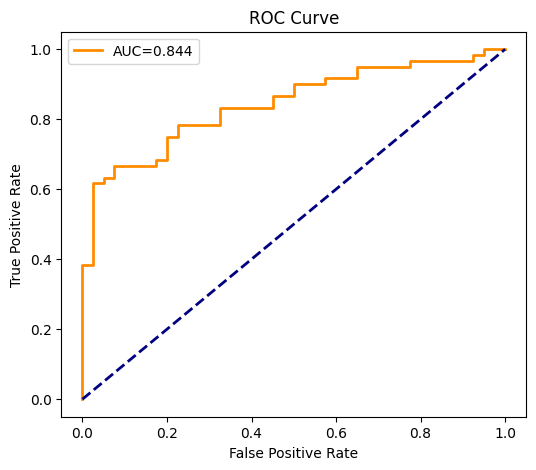

In [12]:
plt.figure(figsize=(6, 5))
fpr, tpr, _ = roc_curve(true_labels, similarity_scores)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC={roc_auc:.3f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.legend()
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

##  Precision-Recall Curve

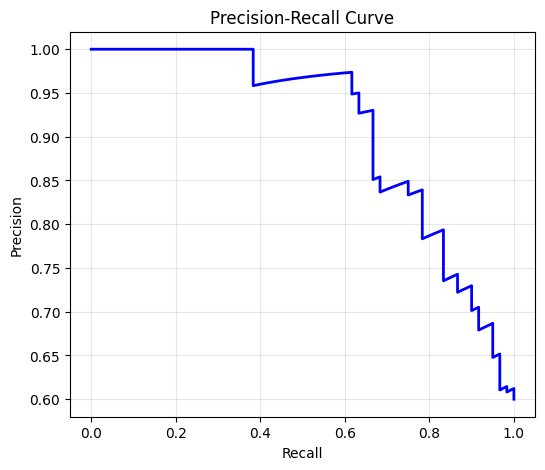

In [13]:
plt.figure(figsize=(6, 5))
precision_curve, recall_curve, _ = precision_recall_curve(true_labels, similarity_scores)
plt.plot(recall_curve, precision_curve, color='blue', lw=2)
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid(alpha=0.3)
plt.show()

## Similarity Distribution

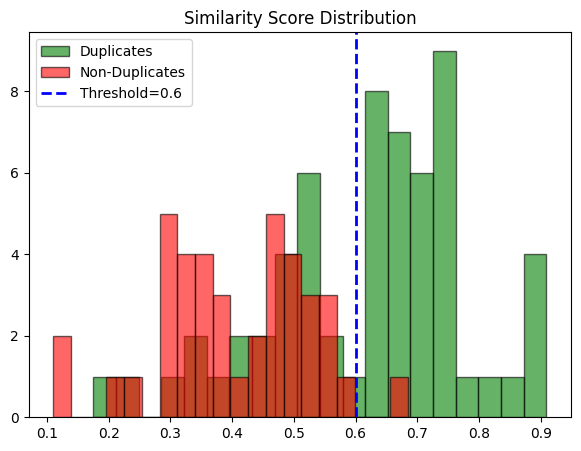

In [14]:
plt.figure(figsize=(7, 5))
duplicate_scores = [similarity_scores[i] for i in range(len(similarity_scores)) if true_labels[i] == 1]
non_duplicate_scores = [similarity_scores[i] for i in range(len(similarity_scores)) if true_labels[i] == 0]
plt.hist(duplicate_scores, bins=20, alpha=0.6, label='Duplicates', color='green', edgecolor='black')
plt.hist(non_duplicate_scores, bins=20, alpha=0.6, label='Non-Duplicates', color='red', edgecolor='black')
plt.axvline(similarity_threshold, color='blue', linestyle='--', linewidth=2, label=f'Threshold={similarity_threshold}')
plt.title('Similarity Score Distribution')
plt.legend()
plt.show()

# ------------------ SNA Metrics ------------------

In [15]:
# stack text1 and text2 into a single column
df_flat = pd.DataFrame({
    "text": pd.concat([df["text1"], df["text2"]], ignore_index=True)
})

df_flat["user_id"] = [str(uuid.uuid4()) for _ in range(len(df_flat))]

In [16]:
df_flat.head()

,text,user_id
0,I love the ocean breeze and sandy shores.,0052545a-d2f2-4852-8e26-228cbb105102
1,Shooting landscapes and street scenes is my ho...,c2e1abde-2b23-4ae5-8ea8-c537571a5992
2,"Stories about wizards, dragons, and epic quest...",4cedc6af-fd1a-4a29-8ff9-496a714929b0
3,Exploring fresh songs and curating playlists i...,ceb0c85d-c26e-4606-a89b-ea8e4303e94d
4,I like discovering new music and building play...,2ba7fdb4-7a91-4f21-908d-d57405cd0a8e


## SNA Metrics for threshold = 0.4

In [17]:
db = VectorDatabase(DB_CONFIG, similarity_threshold=0.4)

In [18]:
#giving user id
df_flat["user_id"] = [str(uuid.uuid4()) for _ in range(len(df_flat))]

def now_iso():
    return datetime.utcnow().isoformat()

# build communities
for txt, uid in zip(df_flat["text"], df_flat["user_id"]):
    out = db.add_or_find_duplicate(txt)  
    group_id = out["id"]               

    COMM.update_one(
        {"_id": group_id},
        {
            "$setOnInsert": {
                "created_at": now_iso(),
                "threshold": db.similarity_threshold
            },
            "$addToSet": { "users": uid }
        },
        upsert=True
    )

In [19]:
# Build user–user graph (edge if two users appear in the same community)
def build_graph_from_mongo(uri=MONGODB_URI, db=DB_NAME, coll=COLLECTION):
    client = MongoClient(uri)
    COMM = client[db][coll]
    G = nx.Graph()

    edge_w = defaultdict(int)
    nodes = set()

    for doc in COMM.find({}, {"users": 1}):
        users = [u for u in (doc.get("users") or []) if u is not None]
        for u in users:
            nodes.add(u)
        for a, b in combinations(sorted(set(users)), 2):
            edge_w[(a, b)] += 1

    G.add_nodes_from(nodes)
    for (a, b), w in edge_w.items():
        G.add_edge(a, b, weight=w)
    return G

G = build_graph_from_mongo()
print(f"Graph built: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")


Graph built: 800 nodes, 37055 edges


## Graph Density

In [20]:
density = nx.density(G) if G.number_of_nodes() > 1 else 0.0
print(f"Graph Density: {density:.3f}")

Graph Density: 0.116


## Average Clustering Coefficient

In [21]:
avg_clustering = nx.average_clustering(G) if G.number_of_nodes() > 0 else 0.0
print(f"Average Clustering Coefficient: {avg_clustering:.3f}")

Average Clustering Coefficient: 0.995


## Degree Centrality

In [22]:
degree_centrality = nx.degree_centrality(G) if G.number_of_nodes() > 0 else {}
max_degree = max(degree_centrality.values()) if degree_centrality else 0.0
print(f"Highest Degree Centrality Score: {max_degree}")

Highest Degree Centrality Score: 0.17897371714643304


## Closeness Centrality

In [23]:
closeness_centrality = nx.closeness_centrality(G) if G.number_of_nodes() > 0 else {}
max_closeness = max(closeness_centrality.values()) if closeness_centrality else 0.0
print(f"Highest Closeness Centrality Score: {max_closeness}")

Highest Closeness Centrality Score: 0.17897371714643304


## Betweenness Centrality

In [24]:
betweenness_centrality = nx.betweenness_centrality(G, normalized=True) if G.number_of_nodes() > 0 else {}
max_betweenness = max(betweenness_centrality.values()) if betweenness_centrality else 0.0
print(f"Highest Betweenness Centrality Score: {max_betweenness}")

Highest Betweenness Centrality Score: 0.0


## Users Belonging to more than one community

In [25]:
user_to_comms = defaultdict(list)

for doc in COMM.find({}, {"_id": 1, "users": 1}):
    community_id = doc["_id"]
    users = doc.get("users", [])
    for u in users:
        user_to_comms[u].append(community_id)


multi_community_users = {u: comms for u, comms in user_to_comms.items() if len(comms) > 1}

print("=== Users in more than one community ===")
if multi_community_users:
    for user, comms in multi_community_users.items():
        print(f"User: {user}\n Communities: {comms}\n")
else:
    print("No users found in more than one community.")

=== Users in more than one community ===
No users found in more than one community.
